In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as cls
import seaborn as sns
import numpy as np
from pathlib import Path
import glob
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'  # Turns on gridlines by default
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['hatch.linewidth'] = 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
#plt.rcParams['axes.spines.bottom'] = False
#plt.rcParams['axes.spines.left'] = False
plt.rcParams.update({'text.color': "black",
                     'axes.labelcolor': "black"})
okabe_ito_palette = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', '#000000']
sns.set_palette(okabe_ito_palette)

In [6]:
"""Load all CSV files from the folder structure"""
print("Loading data from all CSV files...")

all_files = glob.glob("data/lw_csv_cleaned_topic/**/*.csv", recursive=True)
print(f"Found {len(all_files)} CSV files")

all_data = []
for file in all_files:
    try:
        df = pd.read_csv(file)
        # Extract year and month from filename
        parts = Path(file).stem.split('-')
        if len(parts) >= 2:
            df['year'] = int(parts[0])
            df['month'] = int(parts[1])
        all_data.append(df)
    except Exception as e:
        print(f"Error loading {file}: {e}")

if not all_data:
    print("No data found! Check your file paths.")

combined_df = pd.concat(all_data, ignore_index=True)
print(f"Loaded {len(combined_df)} total posts from {len(all_data)} files")

# Clean and prepare data
combined_df['postedAt'] = pd.to_datetime(combined_df['postedAt'], errors='coerce')
combined_df['baseScore'] = pd.to_numeric(combined_df['baseScore'], errors='coerce').fillna(0)
combined_df['commentCount'] = pd.to_numeric(combined_df['commentCount'], errors='coerce').fillna(0)

Loading data from all CSV files...
Found 116 CSV files
Loaded 33020 total posts from 116 files


In [7]:
# nice plot templates
!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -P /tmp

--2025-09-21 16:44:54--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40905 (40K) [text/plain]
Saving to: ‘/tmp/rose-pine-dawn.mplstyle’

rose-pine-dawn.mpls 100%[===================>]  39,95K  --.-KB/s    in 0,09s   

2025-09-21 16:44:55 (427 KB/s) - ‘/tmp/rose-pine-dawn.mplstyle’ saved [40905/40905]



In [8]:
def truncate_colormap(cmap, min_val=0.0, max_val=1.0, n=100):
    """
    Truncate the color map according to the min_val and max_val from the
    original color map.
    """
    new_cmap = cls.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=min_val, b=max_val),
        cmap(np.linspace(min_val, max_val, n)))
    return new_cmap

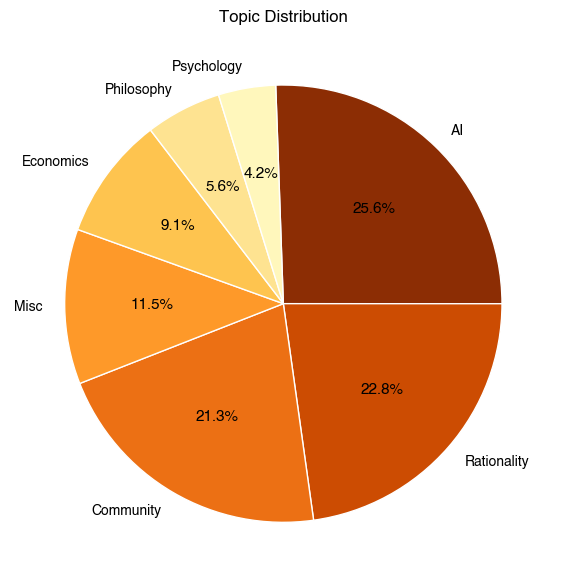

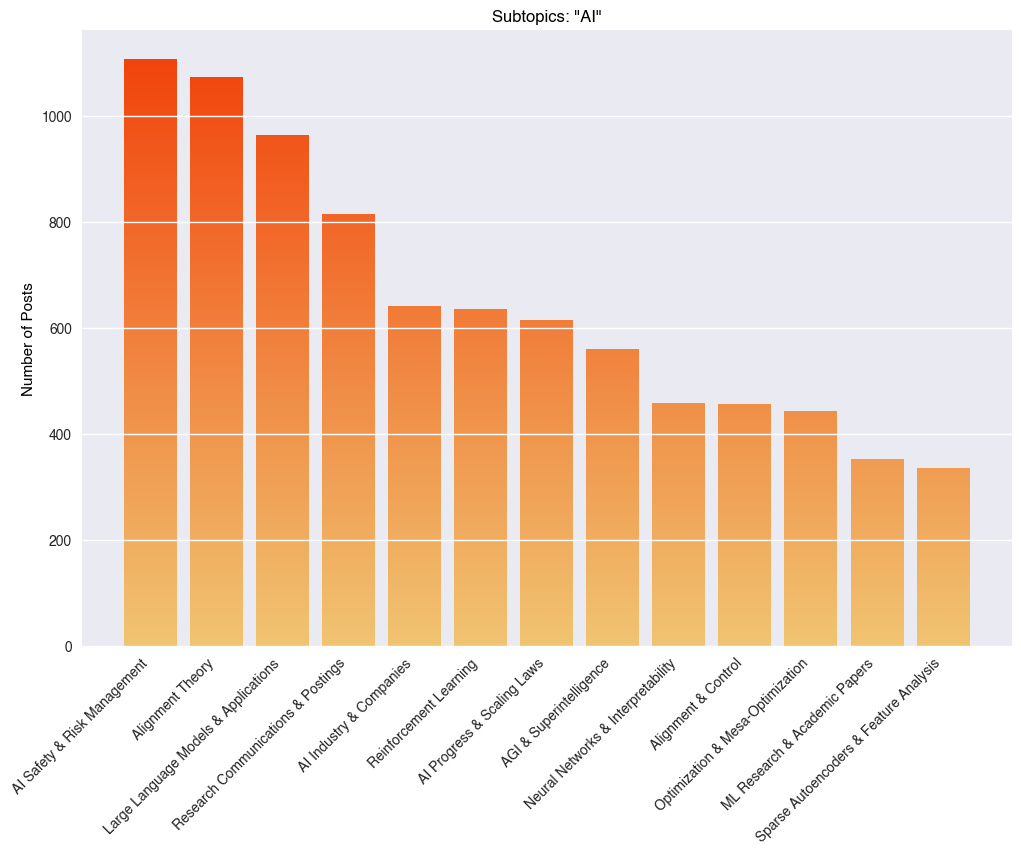

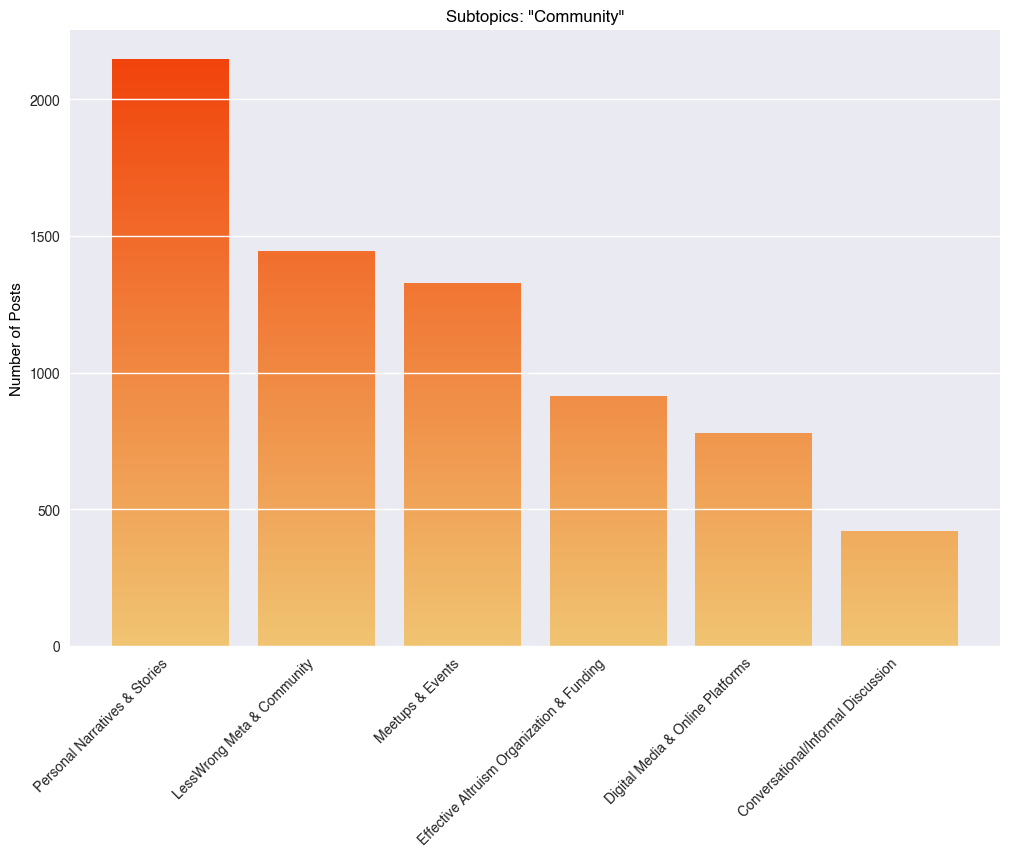

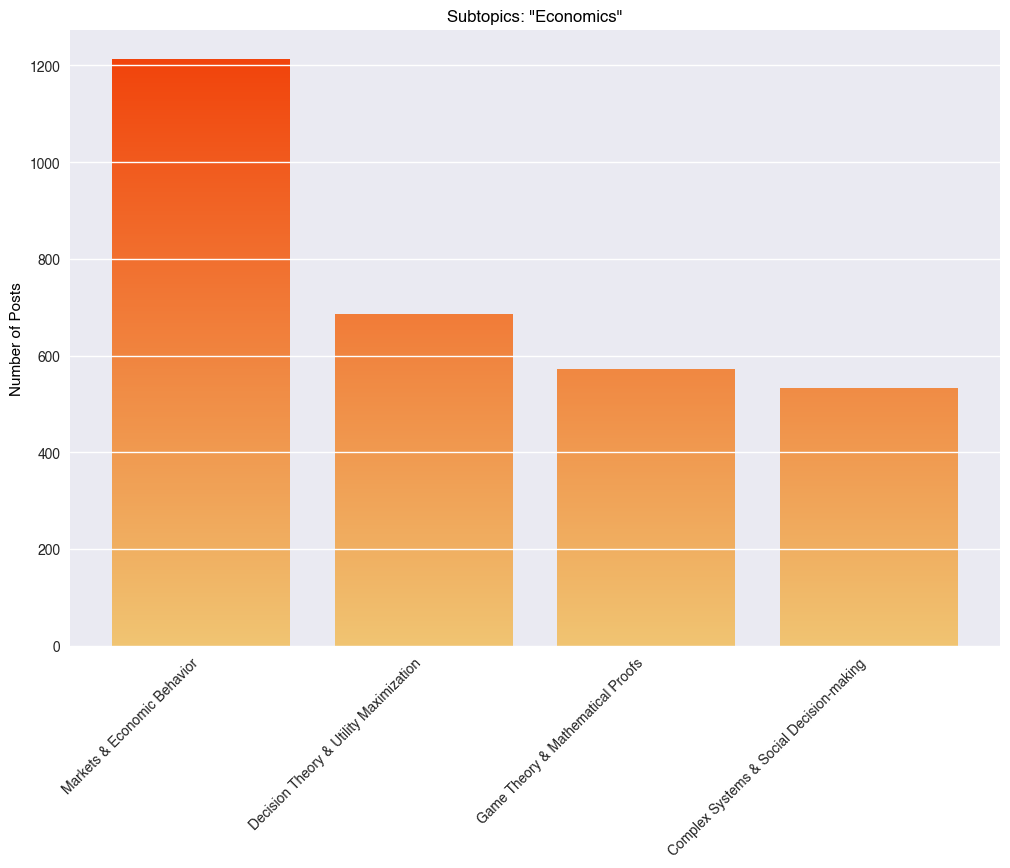

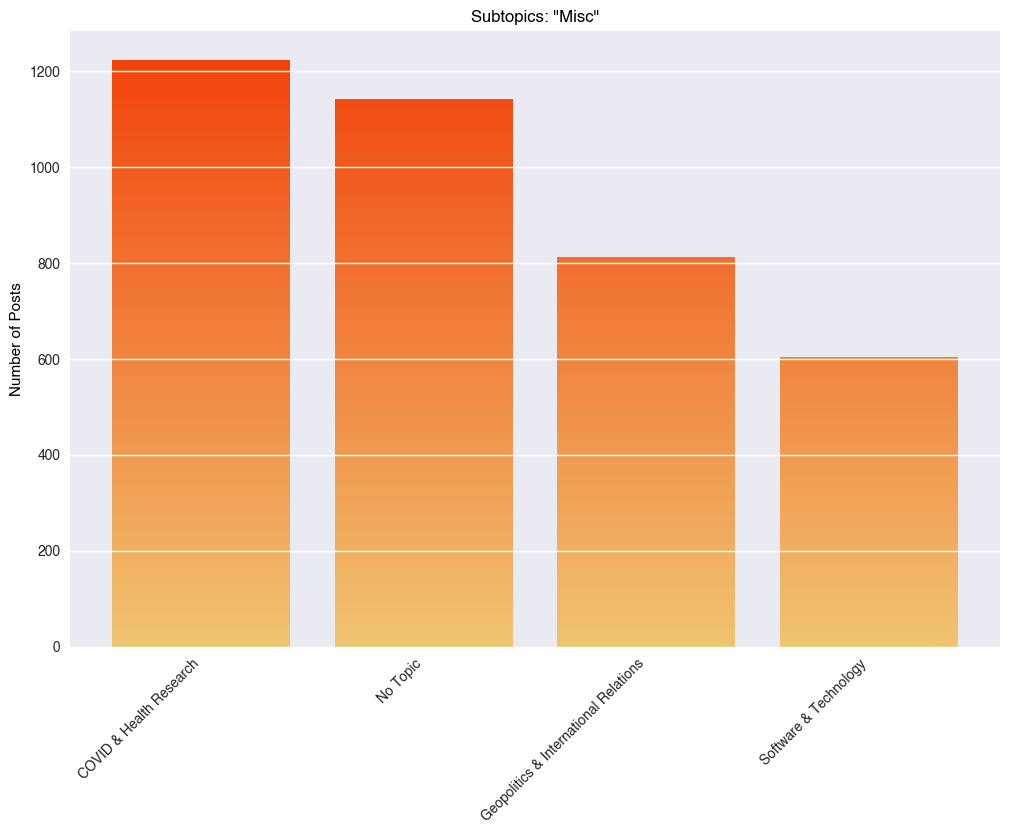

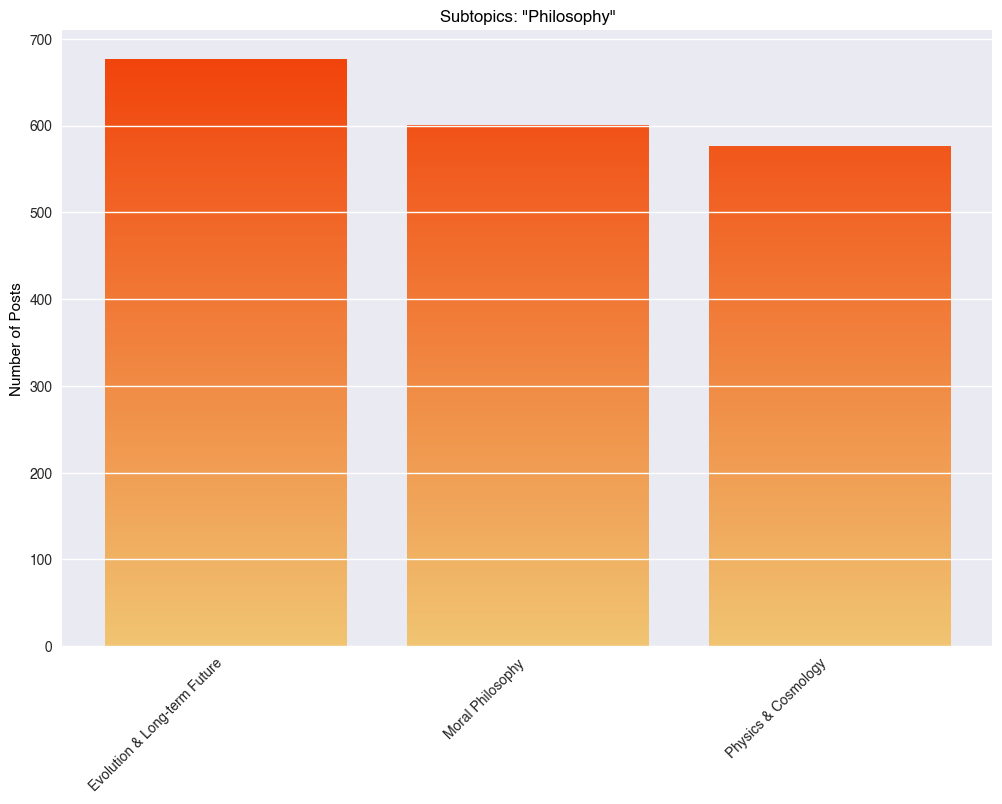

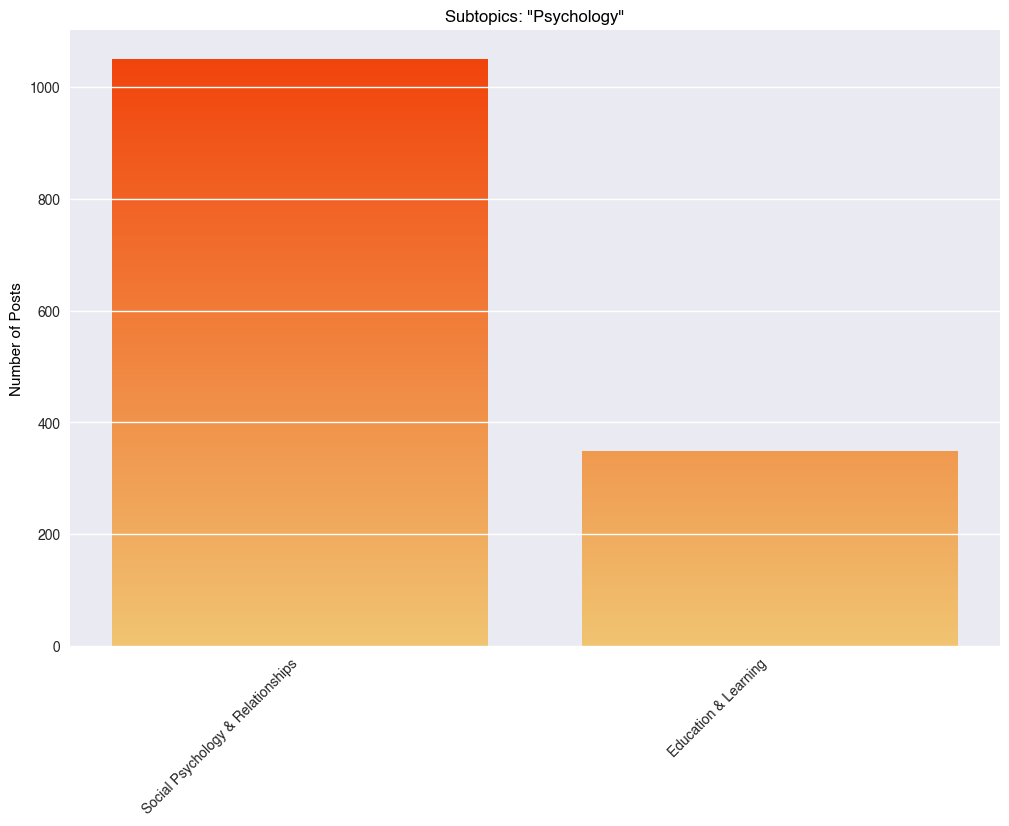

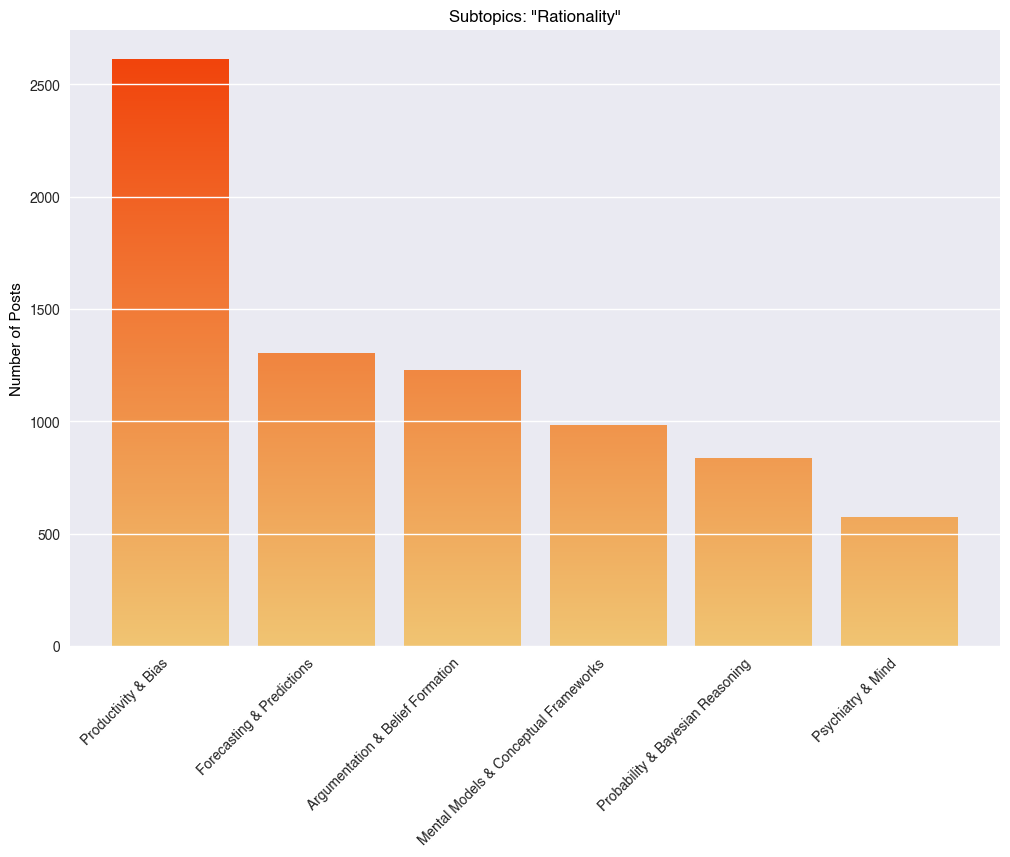

In [9]:
combined_df["super_topic"] = combined_df["topic_label"].str.split(":", n=1).str[0].str.strip()
combined_df["sub_topic"] = combined_df["topic_label"].str.split(":", n=1).str[1].str.strip()

"""=== TOPIC ANALYSIS (Super vs Subtopics) ==="""

# --- Figure 1: Super topic distribution ---
super_counts = combined_df["super_topic"].value_counts()

plt.figure(figsize=(12, 6))
plt.pie(
    super_counts.values,
    labels=super_counts.index,
    autopct='%1.1f%%',
    startangle=92,
    counterclock=False,
    colors = ["#8c2d04", "#cc4c02", "#ec7014", "#fe9929", "#fec44f", "#fee391", "#fff7bc"],
    wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white'}
)
plt.xticks(rotation=45, ha="right")
plt.title("Topic Distribution")
plt.tight_layout()
plt.savefig("img/topic_analysis_super.png", dpi=300, bbox_inches="tight")
plt.show()

base_color = "#f23e07"
cmap = LinearSegmentedColormap.from_list("grad_orange", ["#f0c472", base_color])

# Iterate over super_topics
for super_topic, group in combined_df.groupby("super_topic"):
    sub_counts = group["sub_topic"].value_counts()

    fig, ax = plt.subplots()
    bars = ax.bar(sub_counts.index, sub_counts.values)

    y_min, y_max = ax.get_ylim()
    grad = np.atleast_2d(np.linspace(0, 1, 256)).T
    ax = bars[0].axes  # axis handle
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)  # put the bars in front
        bar.set_facecolor("none")  # make the bars transparent
        x, _ = bar.get_xy()  # get the corners
        w, h = bar.get_width(), bar.get_height()  # get the width and height

        # Define a new color map.
        # For instance, if one bar only takes 10% of the y-axis, then the color
        # map will only use the first 10% of the color map.
        c_map = truncate_colormap(cmap, min_val=0, max_val=(h - y_min) / (y_max - y_min))

        # Let the imshow only use part of the color map
        ax.imshow(grad, extent=[x, x+w, h, y_min], aspect="auto", zorder=0,
                cmap=c_map)
        
    ax.axis(lim)
    ax.set_xticks(range(len(sub_counts)))
    ax.set_xticklabels(sub_counts.index, rotation=45, ha="right")
    ax.set_ylabel("Number of Posts")
    ax.set_title(f'Subtopics: "{super_topic}"')
    plt.savefig(f"img/topic_analysis_sub_{super_topic.replace(' ', '_')}.png",
                dpi=300, bbox_inches="tight")
    plt.show()


=== GENDER ANALYSIS ===

Gender Distribution:
Male: 24,104 (27083.1%)
Female: 4,629 (5201.1%)
Unknown: 4,287 (4816.9%)


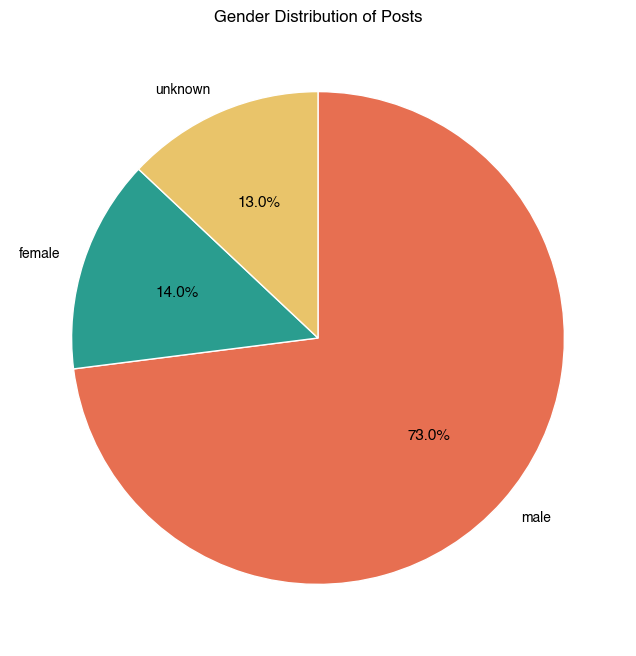

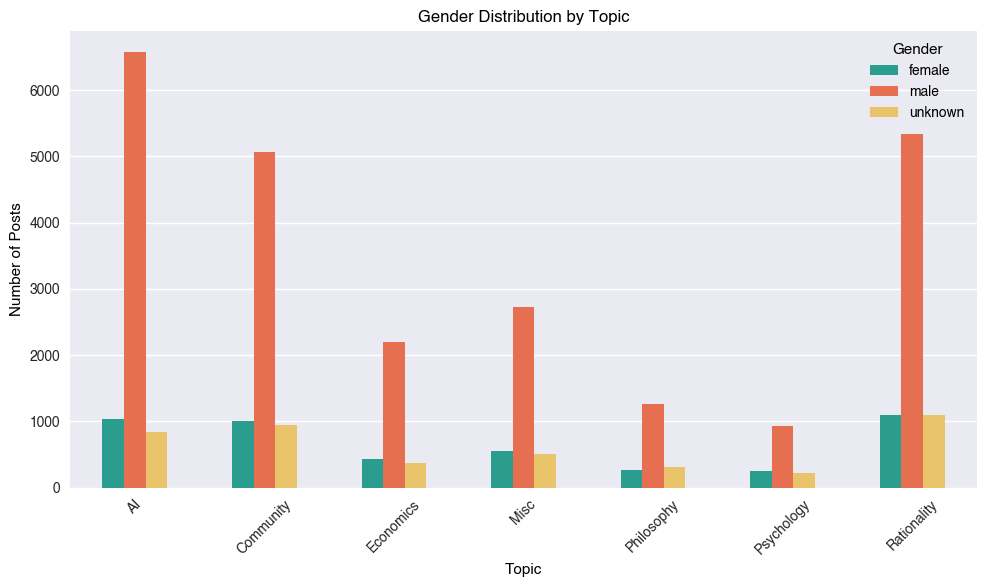

In [10]:
"""Analyze gender distribution"""
print("\n=== GENDER ANALYSIS ===")

gender_counts = combined_df['user_gender'].value_counts()
print(f"\nGender Distribution:")
for gender, count in gender_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{gender.title()}: {count:,} ({percentage:.1f}%)")

# Gender pie chart
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90,
        colors=["#e76f51", "#2a9d8f", "#e9c46a"], 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white'},
        counterclock=False
        )
plt.title('Gender Distribution of Posts')
plt.savefig("img/gender_dist_posts.png", dpi=300, bbox_inches="tight")
plt.show()

# Gender distribution by top topics
gender_topic = combined_df.groupby(['super_topic', 'user_gender']).size().unstack(fill_value=0)
ax = gender_topic.plot(kind="bar", figsize=(10,6), 
                       color=["#2a9d8f", "#e76f51", "#e9c46a"]
                        )
plt.title('Gender Distribution by Topic')
plt.ylabel('Number of Posts')
plt.grid(axis='x')
plt.xlabel('Topic')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("img/gender_topic.png", dpi=300, bbox_inches="tight")
plt.show()


=== AUTHOR ANALYSIS ===

Total unique authors: 5,390
Authors with only 1 post: 2,753 (51.1%)
Authors with 10+ posts: 590
Authors with 50+ posts: 101

Top 10 Most Active Authors:
jkaufman: 980 posts
Zvi: 956 posts
Stuart_Armstrong: 560 posts
Raemon: 372 posts
johnswentworth: 363 posts
lsusr: 291 posts
KatjaGrace: 253 posts
jasoncrawford: 237 posts
habryka4: 227 posts
Chris_Leong: 224 posts


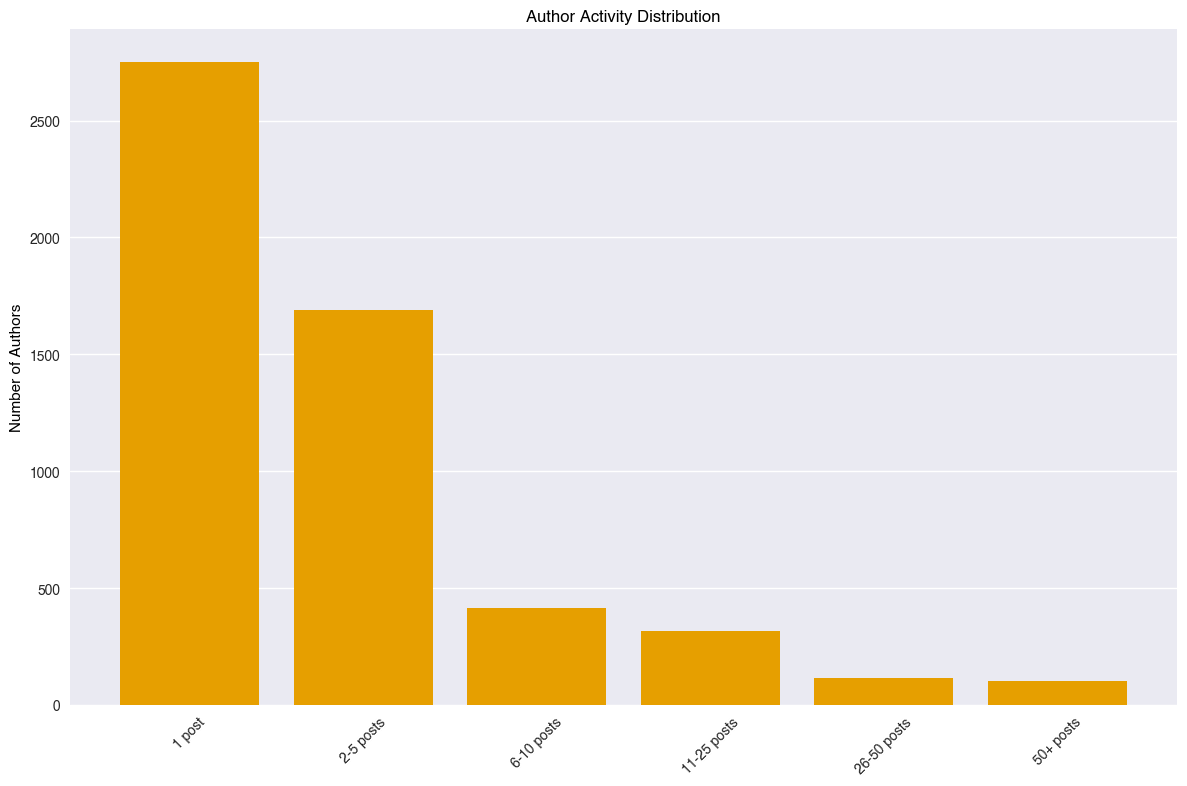

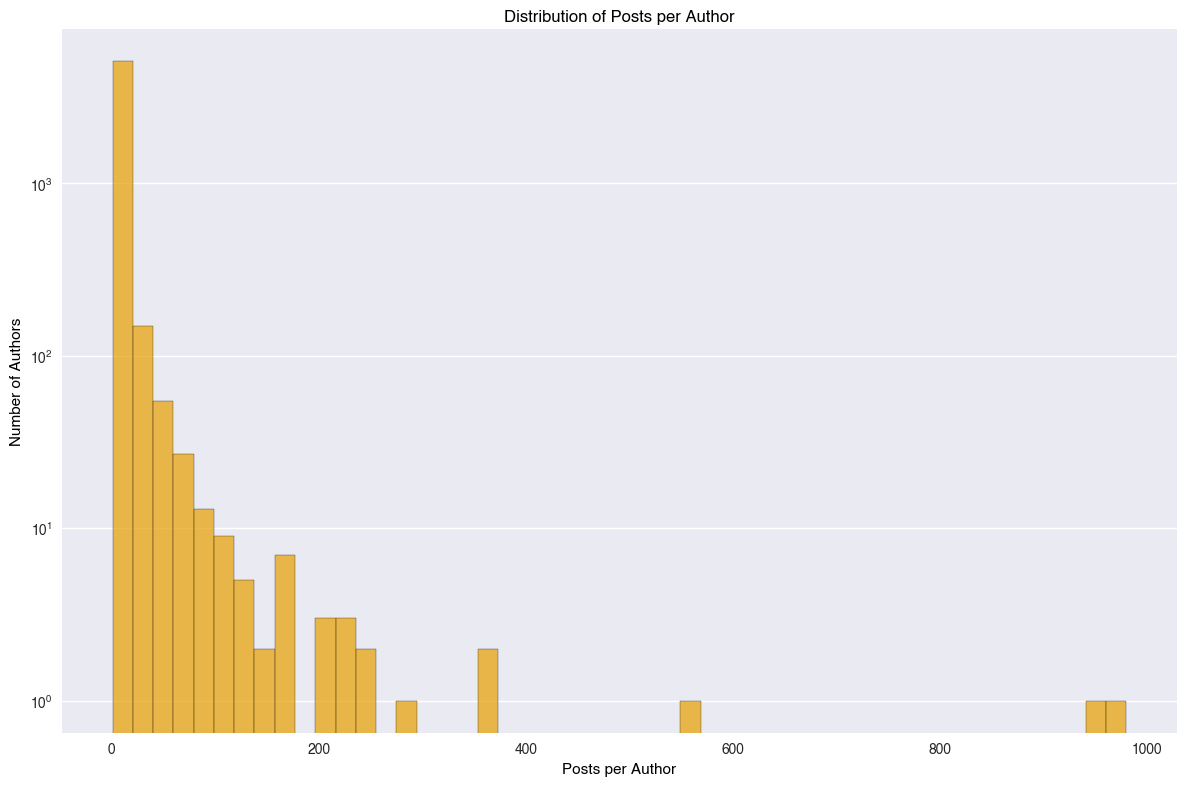

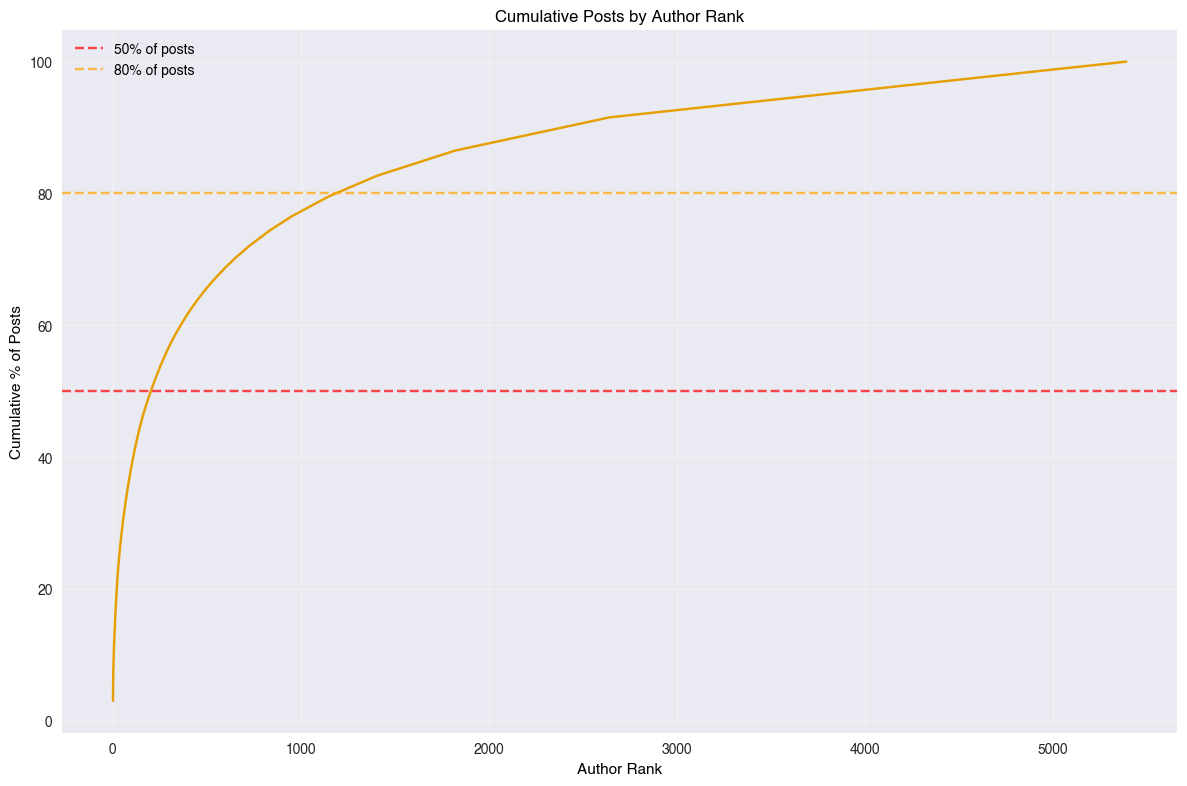

In [11]:
"""Analyze author activity patterns"""
print("\n=== AUTHOR ANALYSIS ===")

author_counts = combined_df['user.username'].value_counts()
print(f"\nTotal unique authors: {len(author_counts):,}")
print(f"Authors with only 1 post: {(author_counts == 1).sum():,} ({((author_counts == 1).sum() / len(author_counts) * 100):.1f}%)")
print(f"Authors with 10+ posts: {(author_counts >= 10).sum():,}")
print(f"Authors with 50+ posts: {(author_counts >= 50).sum():,}")

print(f"\nTop 10 Most Active Authors:")
for author, count in author_counts.head(10).items():
    print(f"{author}: {count} posts")

# Author activity distribution
post_ranges = ['1 post', '2-5 posts', '6-10 posts', '11-25 posts', '26-50 posts', '50+ posts']
counts = [
    (author_counts == 1).sum(),
    ((author_counts >= 2) & (author_counts <= 5)).sum(),
    ((author_counts >= 6) & (author_counts <= 10)).sum(),
    ((author_counts >= 11) & (author_counts <= 25)).sum(),
    ((author_counts >= 26) & (author_counts <= 50)).sum(),
    (author_counts >= 50).sum()
]

plt.bar(post_ranges, counts)
plt.title('Author Activity Distribution')
plt.ylabel('Number of Authors')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig("img/authors_per_number_posts.png", dpi=300, bbox_inches="tight")
plt.show()

# Posts per author histogram (log scale)
plt.hist(author_counts.values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Posts per Author')
plt.ylabel('Number of Authors')
plt.title('Distribution of Posts per Author')
plt.yscale('log')
plt.tight_layout()
plt.savefig("img/posts_per_author_histogram.png", dpi=300, bbox_inches="tight")
plt.show()

# Cumulative posts by author rank
sorted_counts = author_counts.sort_values(ascending=False)
cumulative = sorted_counts.cumsum()
cumulative_pct = cumulative / cumulative.iloc[-1] * 100

plt.plot(range(1, len(cumulative_pct) + 1), cumulative_pct)
plt.xlabel('Author Rank')
plt.ylabel('Cumulative % of Posts')
plt.title('Cumulative Posts by Author Rank')
plt.grid(True, alpha=0.3)
plt.axhline(y=50, color='r', linestyle='--', alpha=0.7, label='50% of posts')
plt.axhline(y=80, color='orange', linestyle='--', alpha=0.7, label='80% of posts')
plt.legend()
plt.tight_layout()
plt.savefig("img/cum_posts_by_author_rank.png", dpi=300, bbox_inches="tight")
plt.show()



=== TEMPORAL TRENDS ===

Posts by Year:
2016: 1,364 posts
2017: 1,798 posts
2018: 1,864 posts
2019: 2,344 posts
2020: 3,117 posts
2021: 3,476 posts
2022: 4,741 posts
2023: 5,704 posts
2024: 4,662 posts
2025: 3,950 posts


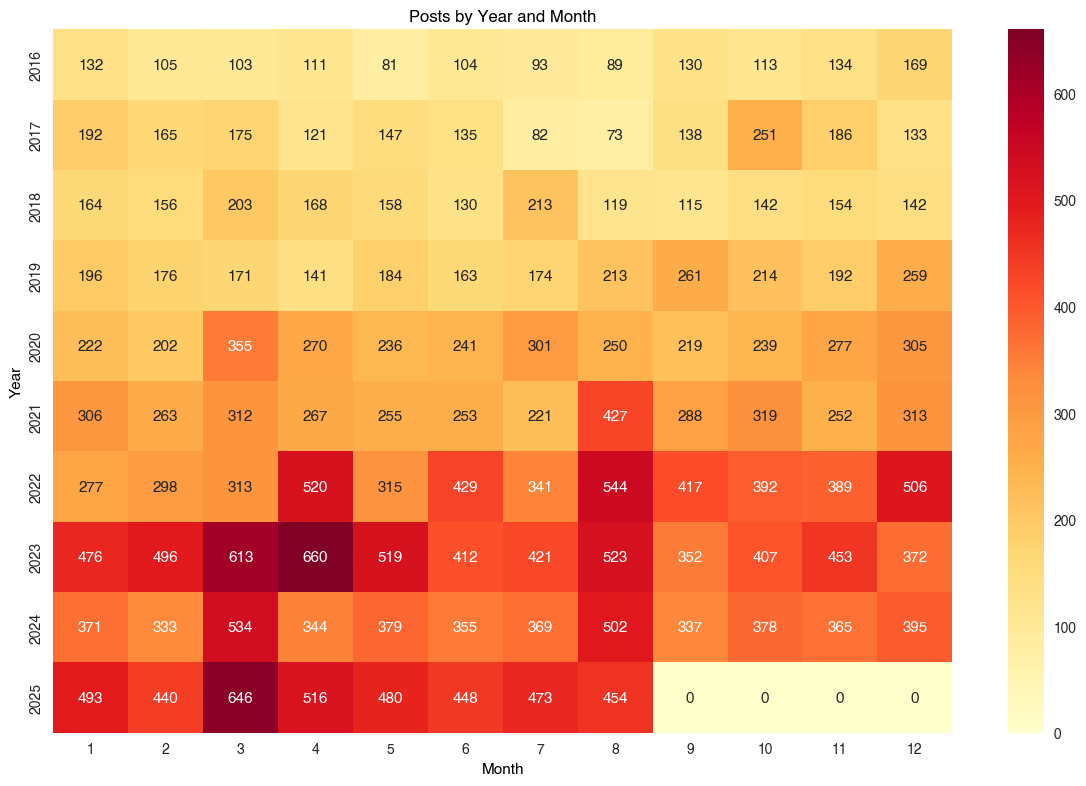

In [32]:
"""Analyze temporal trends"""
print("\n=== TEMPORAL TRENDS ===")

# Posts by year
yearly_posts = combined_df.groupby('year').size()
print(f"\nPosts by Year:")
for year, count in yearly_posts.items():
    print(f"{year}: {count:,} posts")

# Heatmap of posts by year and month
if 'month' in df.columns:
    heatmap_data = combined_df.groupby(['year', 'month']).size().unstack(fill_value=0)
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Posts by Year and Month')
    plt.xlabel('Month')
    plt.ylabel('Year')

plt.tight_layout()
plt.savefig('img/activity_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
"""Generate a comprehensive summary report"""
print("\n" + "="*60)
print("               LESSWRONG DATA SUMMARY REPORT")
print("="*60)

print(f"\n📊 OVERALL STATISTICS:")
print(f"   Total Posts: {len(combined_df):,}")
print(f"   Date Range: {combined_df['year'].min()}-{combined_df['year'].max()}")
print(f"   Unique Authors: {combined_df['user.username'].nunique():,}")
print(f"   Unique Topics: {combined_df['topic_label'].nunique()}")

print(f"\n👥 AUTHOR INSIGHTS:")
author_counts = combined_df['user.username'].value_counts()
print(f"   One-time contributors: {(author_counts == 1).sum():,} ({((author_counts == 1).sum() / len(author_counts) * 100):.1f}%)")
print(f"   Prolific authors (10+ posts): {(author_counts >= 10).sum():,}")
print(f"   Super authors (50+ posts): {(author_counts >= 50).sum():,}")
print(f"   Most prolific: {author_counts.index[0]} with {author_counts.iloc[0]} posts")

print(f"\n🏷️  TOPIC INSIGHTS:")
topic_counts = combined_df['topic_label'].value_counts()
print(f"   Most popular topic: {topic_counts.index[0]} ({topic_counts.iloc[0]:,} posts)")
print(f"   Topics with 100+ posts: {(topic_counts >= 100).sum()}")

print(f"\n🚻 GENDER DISTRIBUTION:")
gender_counts = combined_df['user_gender'].value_counts()
for gender, count in gender_counts.items():
    percentage = (count / len(combined_df)) * 100
    print(f"   {gender.title()}: {count:,} ({percentage:.1f}%)")

print(f"\n📈 ENGAGEMENT METRICS:")
print(f"   Average score: {combined_df['baseScore'].mean():.1f}")
print(f"   Average comments: {combined_df['commentCount'].mean():.1f}")
print(f"   Highest scoring post: {combined_df.loc[combined_df['baseScore'].idxmax(), 'title'][:50]}...")
print(f"   Most commented post: {combined_df.loc[combined_df['commentCount'].idxmax(), 'title'][:50]}...")

print(f"\n📅 TEMPORAL TRENDS:")
yearly_posts = combined_df.groupby('year').size()
peak_year = yearly_posts.idxmax()
print(f"   Peak posting year: {peak_year} with {yearly_posts[peak_year]:,} posts")
print(f"   Growth from {yearly_posts.index[0]} to {yearly_posts.index[-1]}: {((yearly_posts.iloc[-1] / yearly_posts.iloc[0] - 1) * 100):+.1f}%")


               LESSWRONG DATA SUMMARY REPORT

📊 OVERALL STATISTICS:
   Total Posts: 33,020
   Date Range: 2016-2025
   Unique Authors: 5,390
   Unique Topics: 37

👥 AUTHOR INSIGHTS:
   One-time contributors: 2,753 (51.1%)
   Prolific authors (10+ posts): 590
   Super authors (50+ posts): 101
   Most prolific: jkaufman with 980 posts

🏷️  TOPIC INSIGHTS:
   Most popular topic: Rationality: Productivity & Bias (2,612 posts)
   Topics with 100+ posts: 37

🚻 GENDER DISTRIBUTION:
   Male: 24,104 (73.0%)
   Female: 4,629 (14.0%)
   Unknown: 4,287 (13.0%)

📈 ENGAGEMENT METRICS:
   Average score: 31.3
   Average comments: 10.5
   Highest scoring post: AGI Ruin: A List of Lethalities...
   Most commented post: My experience at and around MIRI and CFAR (inspire...

📅 TEMPORAL TRENDS:
   Peak posting year: 2023 with 5,704 posts
   Growth from 2016 to 2025: +189.6%
